<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">scRNA-Seq - Foetal Project</h1> 
    <h2 style="color:#483D8B;text-align:center;">Statistical Analysis Cell Cycle - Femur vs Liver</h2>
    <br>17 April 2020 @ Sanger WTSI
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Research Associate – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at860@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at19@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">   
    <h3 style="color:#483D8B;">Simone G. Riva, MSc</h3><br>
    PhD student – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:sgr34@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:sr31@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import matplotlib
import seaborn as sns
import sys
from scipy import stats
import math

sys.path.append("../Functions")

from scRNA_functions import scRNA_functions

random_state = 8

In [2]:
fc   = scRNA_functions()

 * Initialising ...


# Functions

In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
        ax = plt.gca()
        
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.10, pad=0.04, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.patch.set(hatch='xx', edgecolor='black')
    

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            if float(text.get_text()) == 0.0:
                text.set_text("")

            texts.append(text)
                
    return texts

In [4]:
def plotHeatmaps(dataframeIn):

    for key in dataframeIn.keys():

        print("\t\t\t\t\t************ %s ************"%key)
        dataframe = dataframeIn[key]
        display(dataframe)


        labels = list(set(dataframe["group1"]).union(dataframe["group2"]))

        data     = []
        clusters = list(np.unique(dataframe["annotation"]))

        combinations = []
        for i, label1 in enumerate(labels):
            for j, label2 in enumerate(labels):
                if i<j:

                    filtered = dataframe[(dataframe["group1"] == label1) & (dataframe["group2"] == label2)]
                    if len(filtered) == 0:
                        filtered = dataframe[(dataframe["group2"] == label1) & (dataframe["group1"] == label2)]

                    if len(filtered) == 0:
                        continue

                    combinations.append("%s vs %s"%(label1, label2))

                    subdata = []
                    for c in clusters:
                        values = filtered[filtered["annotation"]==c]["p-value"].tolist()
                        if len(values) == 0:
                            subdata.append(float('nan'))
                        elif values[0] > 1:
                            subdata.append(1)
                        else:
                            subdata.append(values[0])

                    data.append(subdata)

        df = pd.DataFrame(columns=combinations, index=clusters, data=np.array(data).T)

        fig, ax = plt.subplots(1, 1, figsize=(20, 20))

        qrates = np.array([0.0, 0.01, 0.05, 0.1, 1.0])
        norm = matplotlib.colors.BoundaryNorm(np.array([0.0, 0.01, 0.05, 0.1, 1.0]), 4)
        fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[0::][norm(x)])

        im, _ = heatmap(np.array(data).T, clusters, combinations, ax=ax,
                        cmap=plt.get_cmap("RdBu", 4), norm=norm,
                        vmin=-1, vmax=1,
                        cbar_kw=dict(ticks=[0.0, 0.01, 0.05, 0.1, 1.0], format=fmt),
                        cbarlabel="Confidence interval")
        
        annotate_heatmap(im, valfmt="{x:.2e}", size=12, fontweight="bold", textcolors=["white", "white", "white", "white"])

        plt.tight_layout()
        plt.show()

In [5]:
def __fisher_test(d, col1, col2):
        
    indices = d.index.tolist() 
    
    table = [dd[col1][0], dd[col2][0]], [dd[col1][1], dd[col2][1]]
    
    p_val  = stats.fisher_exact(table)[1]
    
    if p_val >= 0.1:
        print("NO difference between %s and %s (p-val: %.3e)"%(indices[0], indices[1], p_val))
    else:
        if p_val <= 0.01:
            print("Strong difference between %s and %s (p-val: %.3e)"%(indices[0], indices[1], p_val))

        elif p_val <= 0.05:
            print("Difference between %s and %s (p-val: %.3e)"%(indices[0], indices[1], p_val))
        else:
            print("Marginal difference between %s and %s (p-val: %.3e)"%(indices[0], indices[1], p_val))
    
    return p_val

# Loading the object

In [6]:
merged = sc.read_h5ad('../Data/ScanpyObjets/MergedAllSamples_annotated.h5ad')

In [7]:
dataframe = pd.DataFrame(columns=["origin", "cluster", "phase", "value", "valueN"])

# Removing Hip

In [8]:
merged = merged[(merged.obs["origin"] == "Femur") | (merged.obs["origin"] == "Liver")]

# Fisher's exact test - cluster by cluster

* Testing cluster CD4+ Monocytes


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  10       27             10                  28
Liver  41       22             40                  22

****************************************************************************************************
Strong difference between Femur and Liver (p-val: 3.912e-04)



* Testing cluster Comm-Prog


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  39       50             53                  40
Liver  26       62             35                  49

****************************************************************************************************
Marginal difference between Femur and Liver (p-val: 5.065e-02)



* Testing cluster Comm-Prog-Cycling


G1  G2M + S  G1 normalised  G2M + S normalised
Femur   4       52             26                  28
Liver  14      163             91                  88

****************************************************************************************************
NO difference between Femur and Liver (p-val: 7.580e-01)



* Testing cluster Dend-Cell-Cycling


* Testing cluster Dendritic cells


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  48       24             37                  34
Liver  33       21             26                  29

****************************************************************************************************
NO difference between Femur and Liver (p-val: 7.196e-01)



* Testing cluster Endothelial cells


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  20        3             11                  12
Liver   9        1              5                   4

****************************************************************************************************
NO difference between Femur and Liver (p-val: 1.000e+00)



* Testing cluster Erythroid Prog


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  76      128            106                 100
Liver  13       31             18                  24

****************************************************************************************************
NO difference between Femur and Liver (p-val: 3.975e-01)



* Testing cluster Granulocyte Prog


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  31       82             62                  55
Liver  11       44             22                  29

****************************************************************************************************
NO difference between Femur and Liver (p-val: 3.141e-01)



* Testing cluster Granulocytes 1


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  25       73             49                  49
Liver   7       20             14                  13

****************************************************************************************************
NO difference between Femur and Liver (p-val: 1.000e+00)



* Testing cluster Granulocytes 2


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  18       51             36                  34
Liver   3       12              6                   8

****************************************************************************************************
NO difference between Femur and Liver (p-val: 7.707e-01)



* Testing cluster Granulocytes 3


G1  G2M + S  G1 normalised  G2M + S normalised
Femur   6       25             13                  16
Liver   3        6              7                   4

****************************************************************************************************
NO difference between Femur and Liver (p-val: 4.801e-01)



* Testing cluster MPP


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  508      221            399                 304
Liver  198      183            156                 251

****************************************************************************************************
Strong difference between Femur and Liver (p-val: 4.247e-09)



* Testing cluster MPP-Cycling


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  39       45             41                  43
Liver  30       31             32                  30

****************************************************************************************************
NO difference between Femur and Liver (p-val: 8.671e-01)



* Testing cluster Mast cells


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  106       43             78                  67
Liver   21       17             15                  26

****************************************************************************************************
Marginal difference between Femur and Liver (p-val: 7.614e-02)



* Testing cluster Mat-B cells


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  139       21             80                  79
Liver   37        6             21                  23

****************************************************************************************************
NO difference between Femur and Liver (p-val: 8.650e-01)



* Testing cluster Megakaryocytes


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  29       39             36                  33
Liver   5       11              6                   9

****************************************************************************************************
NO difference between Femur and Liver (p-val: 5.700e-01)



* Testing cluster Monocytes 1


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  125       25             75                  74
Liver   41        9             25                  26

****************************************************************************************************
NO difference between Femur and Liver (p-val: 1.000e+00)



* Testing cluster Monocytes 2


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  41       72             55                  57
Liver  18       27             24                  22

****************************************************************************************************
NO difference between Femur and Liver (p-val: 8.611e-01)



* Testing cluster NK cells


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  10        5              7                  10
Liver  20        5             13                  10

****************************************************************************************************
NO difference between Femur and Liver (p-val: 5.231e-01)



* Testing cluster Pre-B cells


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  41      167            132                  99
Liver   6       88             19                  52

****************************************************************************************************
Strong difference between Femur and Liver (p-val: 1.075e-05)



* Testing cluster Pro-B cells


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  82       58             69                  71
Liver  27       17             23                  21

****************************************************************************************************
NO difference between Femur and Liver (p-val: 8.629e-01)



* Testing cluster Prog


G1  G2M + S  G1 normalised  G2M + S normalised
Femur  14       67             69                  37
Liver   1       65              5                  36

****************************************************************************************************
Strong difference between Femur and Liver (p-val: 3.804e-09)



* Testing cluster Unspecified


G1  G2M + S  G1 normalised  G2M + S normalised
Femur   2       16             10                   9
Liver   2       20             10                  11

****************************************************************************************************
NO difference between Femur and Liver (p-val: 1.000e+00)



					************ Test ************


group1   group2         annotation       p-value
0      G1  G2M + S     CD4+ Monocytes  3.911768e-04
1      G1  G2M + S          Comm-Prog  5.064813e-02
2      G1  G2M + S  Comm-Prog-Cycling  7.580254e-01
3      G1  G2M + S    Dendritic cells  7.195793e-01
4      G1  G2M + S  Endothelial cells  1.000000e+00
5      G1  G2M + S     Erythroid Prog  3.974759e-01
6      G1  G2M + S   Granulocyte Prog  3.140615e-01
7      G1  G2M + S     Granulocytes 1  1.000000e+00
8      G1  G2M + S     Granulocytes 2  7.706707e-01
9      G1  G2M + S     Granulocytes 3  4.801154e-01
10     G1  G2M + S                MPP  4.246869e-09
11     G1  G2M + S        MPP-Cycling  8.671134e-01
12     G1  G2M + S         Mast cells  7.613516e-02
13     G1  G2M + S        Mat-B cells  8.649934e-01
14     G1  G2M + S     Megakaryocytes  5.700076e-01
15     G1  G2M + S        Monocytes 1  1.000000e+00
16     G1  G2M + S        Monocytes 2  8.611204e-01
17     G1  G2M + S           NK cells  5.231071e-01
18     G1  G2M + S        Pre-B cells  1.075144e-05
19     G1  G2M + S        Pro-B cells  8.629416e-01
20     G1  G2M + S               Prog  3.804027e-09
21     G1  G2M + S        Unspecified  1.000000e+00

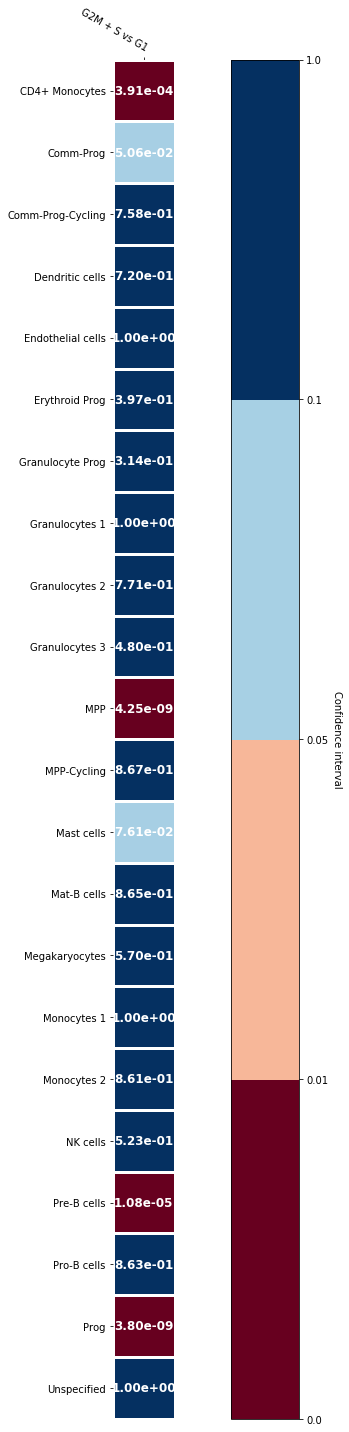

In [9]:
df = pd.DataFrame(columns=["group1", "group2", "annotation", "p-value"])
dictionaryOut = {}

p_vals    = []
group1    = []
group2    = []
variables = []


for cluster in np.unique(merged.obs["annotation"]):
    
    print("* Testing cluster %s"%cluster)
    subset = merged[merged.obs["annotation"]==cluster]
    femur = subset[subset.obs["origin"]=="Femur"]
    liver = subset[subset.obs["origin"]=="Liver"]
    
    femurG1    = femur[femur.obs["phase"]=="G1"].n_obs
    femurG2M_S = femur[femur.obs["phase"]!="G1"].n_obs

    liverG1    = liver[liver.obs["phase"]=="G1"].n_obs
    liverG2M_S = liver[liver.obs["phase"]!="G1"].n_obs
    
    fc.plotPieCharts(subset, variable="phase", group_by="origin")
        
    if femurG1 == 0 or femurG2M_S == 0 or liverG1 == 0 or liverG2M_S == 0:
        continue

    dd = pd.DataFrame(columns=["G1", "G2M + S"],
                      index=["Femur", "Liver"],
                      data=[[femurG1,femurG2M_S], [liverG1, liverG2M_S]])

    col1 = dd.columns.tolist()[0]
    col2 = dd.columns.tolist()[1]

    sum1 = np.sum(dd[col1].values.tolist())
    sum2 = np.sum(dd[col2].values.tolist())

    avg = (sum1+sum2)/2

    dd[col1+" normalised"] = np.round(avg*(np.array(dd[col1].values.tolist())/sum1), decimals=0).astype(int)
    dd[col2+" normalised"] = np.round(avg*(np.array(dd[col2].values.tolist())/sum2), decimals=0).astype(int)

    display(dd)

    print("*"*100)
    p_val = __fisher_test(dd, col1+" normalised", col2+" normalised")
    
    dataframe = dataframe.append({'origin':'Femur',
                              'cluster':cluster,
                              'phase':"G1",
                              'value':dd["G1"][0],
                              'valueN':dd["G1 normalised"][0]},
                             ignore_index=True)

    dataframe = dataframe.append({'origin':'Femur',
                              'cluster':cluster,
                              'phase':"G2M+S",
                              'value':dd["G2M + S"][0],
                              'valueN':dd["G2M + S normalised"][0]},
                             ignore_index=True)

    dataframe = dataframe.append({'origin':'Liver',
                              'cluster':cluster,
                              'phase':"G1",
                              'value':dd["G1"][1],
                              'valueN':dd["G1 normalised"][1]},
                             ignore_index=True)

    dataframe = dataframe.append({'origin':'Liver',
                              'cluster':cluster,
                              'phase':"G2M+S",
                              'value':dd["G2M + S"][1],
                              'valueN':dd["G2M + S normalised"][1]},
                             ignore_index=True)
    
    print("\n\n")
    
    p_vals.append(p_val)
    group1.append("G1")
    group2.append("G2M + S")
    variables.append(cluster)    

df["group1"]      = group1
df["group2"]      = group2
df["annotation"]  = variables
df["p-value"]     = p_vals

if dataframe.shape[0] > 0:
    dictionaryOut["Test"] = df
    plotHeatmaps(dictionaryOut)